In [1]:
import warnings, sys
warnings.filterwarnings("ignore")

In [33]:
import pandas as pd, numpy as np,os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, auc, roc_curve, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
import string, re
from collections import Counter

# Plot Imports
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud

# Model Imports
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# NLP imports
import nltk
from nltk import wordnet
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from string import punctuation
from sklearn.decomposition import TruncatedSVD
from string import punctuation

# Word2vec
# import gensim
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shard\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shard\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [13]:
# os.getcwd()
train = pd.read_csv('C:\\Users\\shard\\Desktop\\Work\\python class\\GA Hackathon - Sentiment Analysis\\data\\train.csv')

In [14]:
train.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [15]:
test = pd.read_csv('C:\\Users\\shard\\Desktop\\Work\\python class\\GA Hackathon - Sentiment Analysis\\data\\test.csv')

In [16]:
test.head()

,tweet_id,tweet
0,7506,Audience Q: What prototyping tools do you use?...
1,7992,At SXSW? Send Your Best Photos &amp; Videos to...
2,247,@mention and here's a pic of you winning your...
3,7688,Google Marissa Mayer: mobile phone as a cursor...
4,3294,#SXSW Google maps is even cooler than I thought


In [17]:
label_map = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE", 3: "CANT_TELL"}
def label_sentiment(label):
    return label_map[int(label)]

In [18]:
train['sentiment_label'] = train['sentiment'].apply(lambda x: label_sentiment(x))

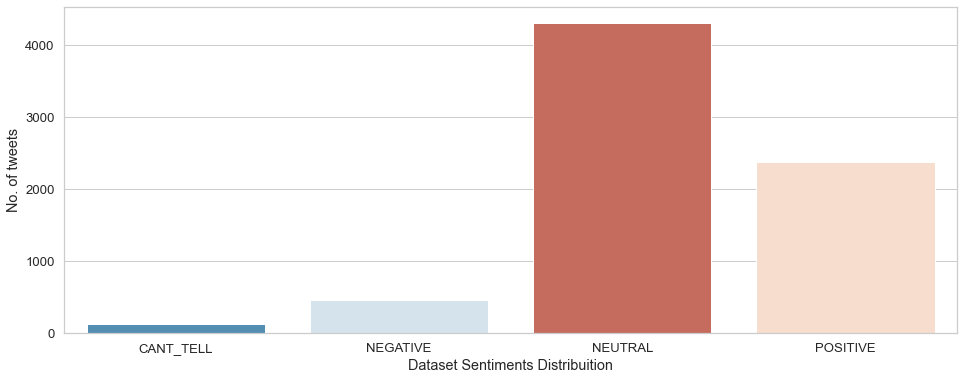

In [19]:
sns.set(style="whitegrid", color_codes=True, font_scale=1.2)

data = train.groupby("sentiment_label").size()

pal = sns.color_palette("RdBu", len(data))
rank = data.argsort().argsort()
plt.figure(figsize=(16, 6))
ax = sns.barplot(x=data.index, y=data, palette=np.array(pal[::-1])[rank])
ax.set(xlabel='Dataset Sentiments Distribuition', ylabel='No. of tweets')

plt.show()

In [20]:
wordnet_lemmatizer = WordNetLemmatizer()

In [24]:
def extract_hashtag(tweet):
    tweets = " ".join(filter(lambda x: x[0]== '#', str(tweet).split()))
    tweets = re.sub('[^a-zA-Z]',' ',  tweets)
    tweets = tweets.lower()
    tweets = [wordnet_lemmatizer.lemmatize(word) for word in tweets]
    tweets = "".join(tweets)
    return tweets

In [31]:
train['tweet_htags'] = train['tweet'].apply(extract_hashtag, 1)

In [34]:
stop_words = stopwords.words('english')
stop_words.append("sxsw")
stop_words.append("...")
custom = stop_words+list(punctuation)
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt 

def preprocess(text):
    text = str(text).lower()
    text = remove_pattern(str(text), "@[\w]*")
    text = remove_pattern(str(text), "#[\w]*")
    text = text.replace("{link}", "")
    tokens = tknzr.tokenize(text)
    tokens = [t for t in tokens if len(t)>2] #remove words lesser than 2 in length
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] #lemmatize words
    tokens = [t for t in tokens if t not in custom] #remove stopwords and punctuation
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)] # remove digits
    s = " ".join(tokens)
    
    return s

In [35]:
train['clean_tweet'] = train['tweet'].apply(preprocess, 1)

In [36]:
train['clean_tweet'] = train['clean_tweet'].str.replace("[^a-zA-Z'#]"," ")

In [38]:
train.head(170)

,tweet_id,tweet,sentiment,sentiment_label,tweet_htags,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,NEUTRAL,sxswnui sxsw apple,defining language touch different dialect beco...
1,1851,Learning ab Google doodles! All doodles should...,1,NEUTRAL,googledoodle sxsw,learning google doodle doodle light funny inno...
2,2689,one of the most in-your-face ex. of stealing t...,2,POSITIVE,sxsw,one in your face stealing show yr apple school...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,NEGATIVE,sxsw fuckit illmakeitwork,iphone app would pretty awesome crash every ex...
4,3604,Line outside the Apple store in Austin waiting...,1,NEUTRAL,sxsw,line outside apple store austin waiting new ipad
...,...,...,...,...,...,...
165,5216,RT @mention #Apple to open pop up store at #SX...,1,NEUTRAL,apple sxsw ipad,open pop store time sale
166,5962,RT @mention Have decided I need an ipad. #usgu...,2,POSITIVE,usguys sxsw,decided need ipad agree
167,4319,Yup. RT @mention I woke up before my iPhone fi...,1,NEUTRAL,sxsw,yup woke iphone finished recharging mean got e...
168,3174,Platform for Concertgoers Launches Android App...,1,NEUTRAL,sxsw,platform concertgoers launch android app time


In [39]:
def generate_word_cloud(tweets):
    all_words = ' '.join([text for text in tweets])
    wordcloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

NEGATIVE TWEETS :  456


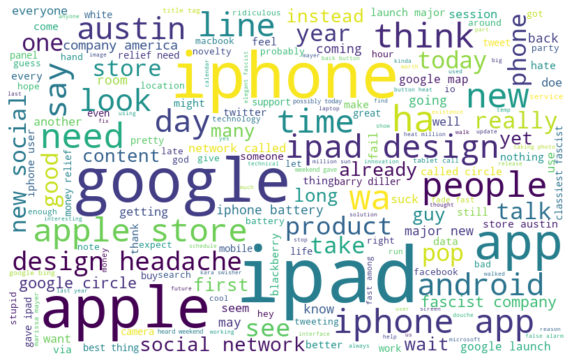

NEUTRAL TWEETS :  4311


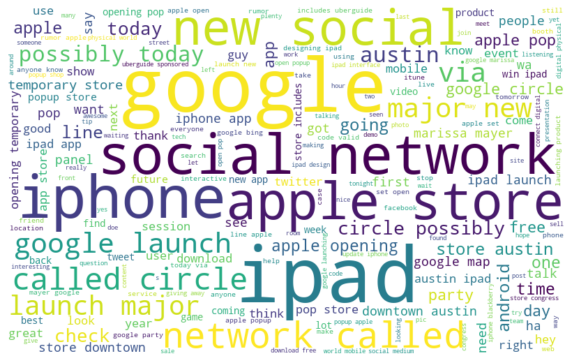

POSITIVE TWEETS :  2382


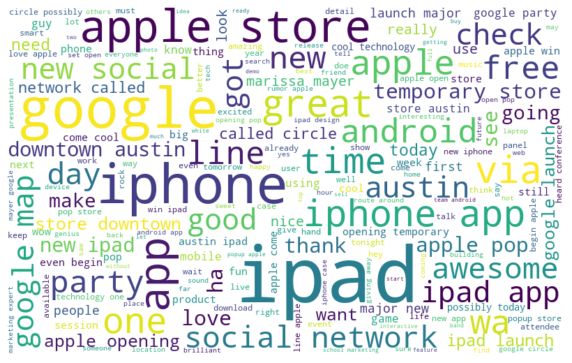

CANT_TELL TWEETS :  125


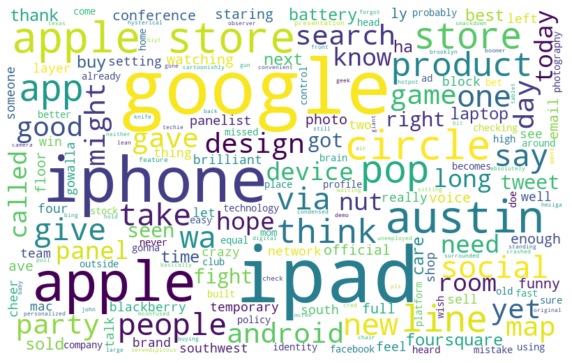

In [55]:
for i in set(train.sentiment_label):
    print(i ,'TWEETS : ', train[train['sentiment_label'] == i].shape[0])
    generate_word_cloud(train.loc[train['sentiment_label'] == i,'clean_tweet']) 

In [56]:
def generate_htag_freq(htag_words):
    #Collect all hashtags
    word_htag = [htag for htag in htag_words.split() if htag != 'sxsw']
    #Count frequency of each word
    word_htag_freqcount = nltk.FreqDist(word_htag)
    word_htag_df = pd.DataFrame({'Hashtag' : list(word_htag_freqcount.keys()),
                                'Count' : list(word_htag_freqcount.values())})


    #Select top 20 most frequent hashtags and plot them   
    most_frequent = word_htag_df.nlargest(columns="Count", n = 20) 
    plt.figure(figsize=(16,5))
    ax = sns.barplot(data=most_frequent, x= "Hashtag", y = "Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set(ylabel = 'Count')
    plt.show()

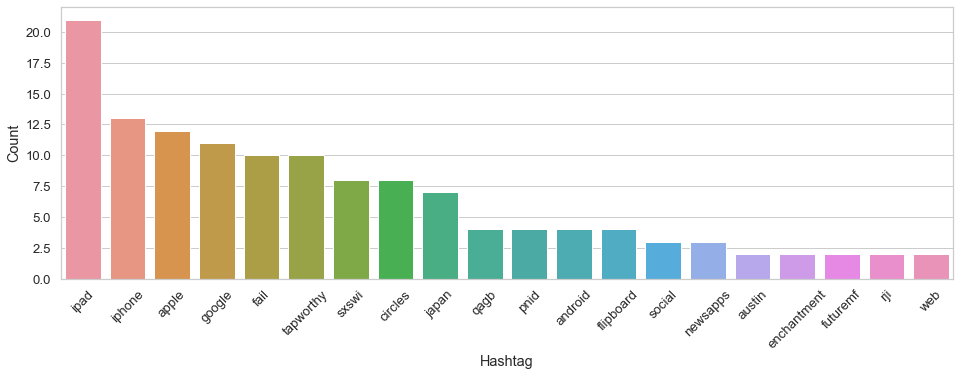

In [57]:
#Select all words from normal tweet
neutral_words = ' '.join([word for word in train['tweet_htags'][train['sentiment'] == 0]])
generate_htag_freq(neutral_words)

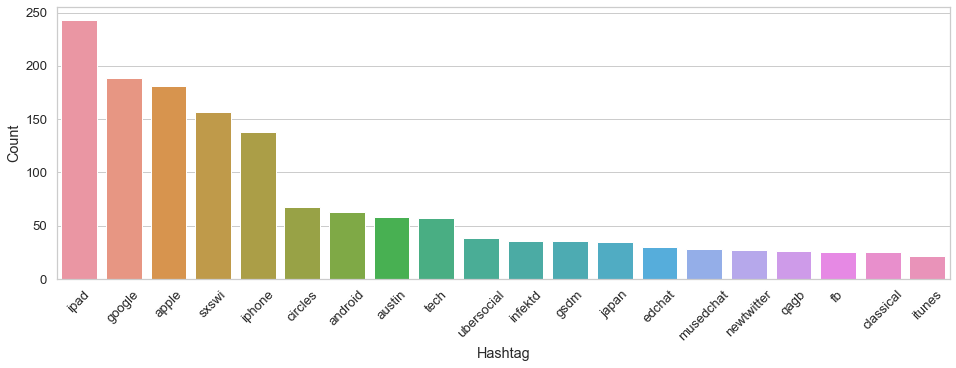

In [58]:
#Select all words from normal tweet
pos_words = ' '.join([word for word in train['tweet_htags'][train['sentiment'] == 1]])
generate_htag_freq(pos_words)

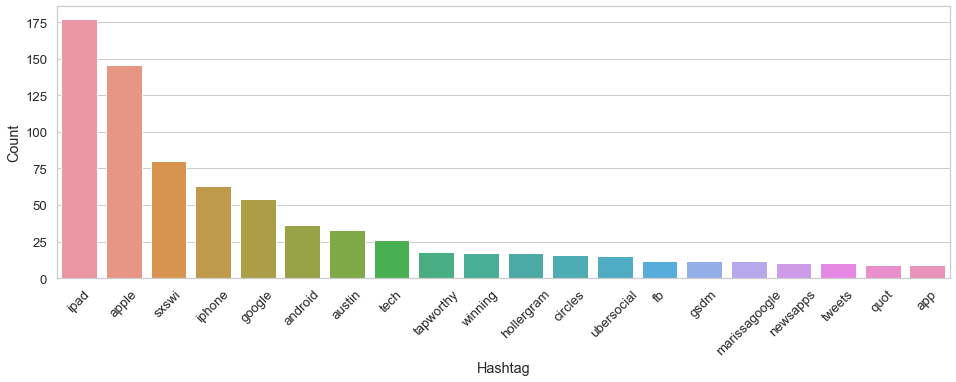

In [59]:
#Select all words from normal tweet
neg_words = ' '.join([word for word in train['tweet_htags'][train['sentiment'] == 2]])
generate_htag_freq(neg_words)

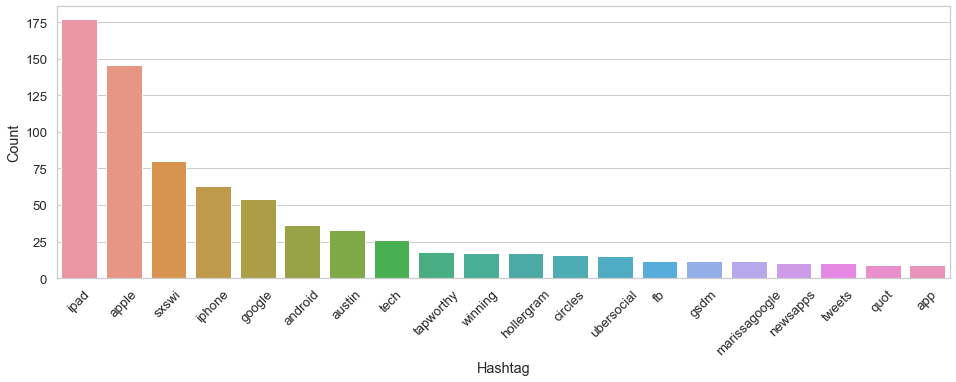

In [60]:
#Select all words from normal tweet
cnt_tell_words = ' '.join([word for word in train['tweet_htags'][train['sentiment'] == 2]])
generate_htag_freq(cnt_tell_words)

In [90]:
# to create sparse matrix corpus is created to pass to vectorizer
corpus = []
for i in range(0,len(train)):
    text = re.sub(' +', ' ', train['clean_tweet'][i])
    corpus.append(text)

In [91]:
new_train = pd.DataFrame(corpus, columns=["sentence"])

In [92]:
new_train['sentiment'] = train['sentiment']

In [93]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(train['clean_tweet'])

In [94]:
# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = tts(bow, train['sentiment'], random_state=42, test_size=0.3)

In [95]:
svc = LinearSVC(random_state=42,C=.5,tol=1,max_iter = 2000)
svc.fit(xtrain_bow, ytrain)
y_pred = svc.predict(xvalid_bow)
print(classification_report(yvalid, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.21      0.26       121
           1       0.69      0.78      0.74      1304
           2       0.54      0.47      0.50       719
           3       0.00      0.00      0.00        39

    accuracy                           0.64      2183
   macro avg       0.39      0.37      0.38      2183
weighted avg       0.61      0.64      0.62      2183



In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer,f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [96]:
rfc = RandomForestClassifier(random_state=42,oob_score=True)
params = {'n_estimators' : range(1000,2051,100)}
scorer = make_scorer(f1_score, average = 'weighted')
svc = LinearSVC(random_state=42,C=.5,tol=1,max_iter = 2000)
cvec = CountVectorizer(max_features=100000, stop_words='english', ngram_range=(1, 3))
tftransform = TfidfTransformer()

In [102]:
pipeline = Pipeline([
    ('vectorizer', cvec),
    ('transformer',tftransform),
    ('classifier', svc)
])

xtrain, xvalid, ytrain, yvalid = tts(train['clean_tweet'], train['sentiment'], random_state=42, test_size=0.3)

model = pipeline.fit(xtrain, ytrain)
prediction = model.predict(xvalid)
print(classification_report(yvalid, prediction))

              precision    recall  f1-score   support

           0       0.57      0.24      0.34       121
           1       0.72      0.81      0.76      1304
           2       0.57      0.52      0.55       719
           3       0.25      0.03      0.05        39

    accuracy                           0.67      2183
   macro avg       0.53      0.40      0.42      2183
weighted avg       0.65      0.67      0.65      2183

